In [3]:
!pip install monai

import torch
from monai.networks.nets import UNet
from monai.transforms import LoadImage, EnsureChannelFirst, Resize, ScaleIntensity
import matplotlib.pyplot as plt
import numpy as np
import cv2


# Load a pre-trained U-Net model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

# Load pre-trained weights
model_path = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/pretrained_models/unet_lung_segmentation.pt"
state_dict = torch.hub.load_state_dict_from_url(model_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()

# Load and preprocess the input X-ray image
image_path = "d:\semester 5\Image Processing\00000003_001.png"
transform = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    ScaleIntensity(),
    Resize((512, 512))
])

input_image = transform(image_path).unsqueeze(0).to(device)

# Perform inference
with torch.no_grad():
    output = model(input_image)
    segmentation_mask = torch.sigmoid(output).squeeze().cpu().numpy()

# Overlay mask on the original image
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
segmentation_resized = cv2.resize((segmentation_mask > 0.5).astype(np.uint8) * 255, (original_image.shape[1], original_image.shape[0]))
overlay = cv2.applyColorMap(segmentation_resized, cv2.COLORMAP_JET)
output_image = cv2.addWeighted(cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR), 0.7, overlay, 0.3, 0)

# Display the result
plt.imshow(output_image)
plt.title("Lung Segmentation")
plt.axis("off")
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 14.1 MB/s eta 0:00:00


Downloading: "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/pretrained_models/unet_lung_segmentation.pt" to /root/.cache/torch/hub/checkpoints/unet_lung_segmentation.pt


HTTPError: HTTP Error 404: Not Found

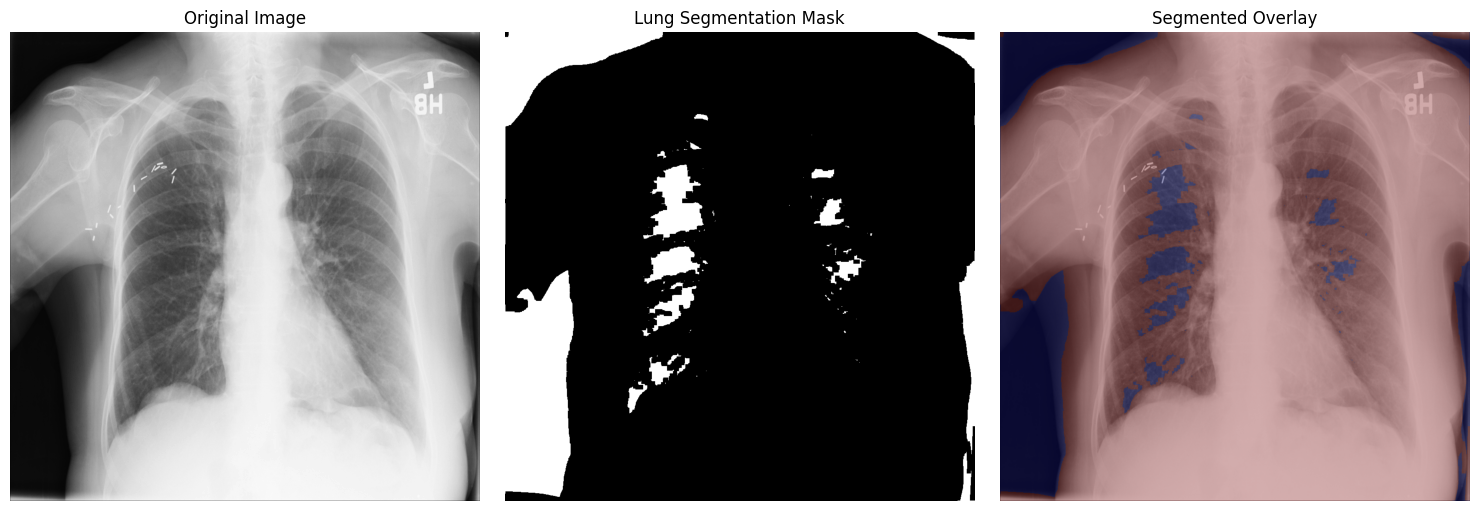

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the X-ray image
image_path = "/content/00000003_001.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply contrast enhancement (CLAHE)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced_image = clahe.apply(image)

# Apply thresholding to segment the lungs
_, thresholded = cv2.threshold(enhanced_image, 50, 255, cv2.THRESH_BINARY_INV)

# Use morphological operations to refine the mask
kernel = np.ones((5, 5), np.uint8)
thresholded = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel, iterations=2)

# Find contours and create a mask
contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask = np.zeros_like(image)
cv2.drawContours(mask, contours, -1, 255, thickness=-1)

# Overlay mask on the original image
overlay = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
output_image = cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR), 0.7, overlay, 0.3, 0)

# Display results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image, cmap="gray")
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(mask, cmap="gray")
ax[1].set_title("Lung Segmentation Mask")
ax[1].axis("off")

ax[2].imshow(output_image)
ax[2].set_title("Segmented Overlay")
ax[2].axis("off")

plt.tight_layout()
plt.show()


In [3]:
import cv2
import numpy as np
import os

def extract_frames(video_path, num_frames=4):
    """
    Extracts `num_frames` evenly spaced frames from a video.
    Returns a list of OpenCV images (numpy arrays).
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Could not open video: {video_path}")

    # Read total number of frames in the video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Generate indices for frames to capture
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=np.int32)

    extracted_images = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            print(f"Failed to read frame at index {idx}.")
            continue
        extracted_images.append(frame)

    cap.release()
    return extracted_images

def enhance_histogram_ycrcb(image):
    """
    Enhance an image by performing histogram equalization in the YCrCb color space.
    """
    # Convert from BGR to YCrCb
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    # Split into channels
    y, cr, cb = cv2.split(ycrcb)
    # Equalize histogram of the Y channel only
    y_eq = cv2.equalizeHist(y)
    # Merge back
    ycrcb_eq = cv2.merge([y_eq, cr, cb])
    # Convert back to BGR
    enhanced_img = cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2BGR)
    return enhanced_img

def morphological_enhancement(image, kernel_size=3, operation='open'):
    """
    Apply a morphological operation to enhance the image.
    Supported operations: 'open', 'close', 'dilate', 'erode'.
    """
    # Convert to grayscale for morphological operations
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Create a structuring element
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))

    if operation == 'open':
        morphed = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
    elif operation == 'close':
        morphed = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    elif operation == 'dilate':
        morphed = cv2.dilate(gray, kernel, iterations=1)
    elif operation == 'erode':
        morphed = cv2.erode(gray, kernel, iterations=1)
    else:
        raise ValueError("Unsupported morphological operation.")

    # Convert back to BGR so further processing can continue in color
    morphed_bgr = cv2.cvtColor(morphed, cv2.COLOR_GRAY2BGR)
    return morphed_bgr

def compress_and_save(image, output_path, quality=70):
    """
    Compress and save the image as a JPEG with the specified quality (0-100).
    """
    cv2.imwrite(output_path, image, [cv2.IMWRITE_JPEG_QUALITY, quality])

def main():
    # ==== 1. Extract 4 frames from the video ====
    video_file = r'c:\Users\RTX\Videos\Screen Recordings\Screen Recording 2024-12-02 200524.mp4'  # Change this to your video path
    extracted_images = extract_frames(video_file, num_frames=4)
    print(f"Extracted {len(extracted_images)} frames.")

    # Directory for output images
    os.makedirs("output_frames", exist_ok=True)

    for i, img in enumerate(extracted_images):
        # Show the Extracted Frame
        cv2.imshow(f"Step 1: Extracted Frame {i}", img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()  # Close all windows

        # ==== 2. Enhance the image (Histogram Equalization in YCrCb) ====
        enhanced_img = enhance_histogram_ycrcb(img)

        # Show the Enhanced Frame
        cv2.imshow(f"Step 2: Enhanced Frame {i}", enhanced_img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()  # Close all windows

        # ==== 3. Morphological Image Processing for enhancement ====
        morphed_img = morphological_enhancement(enhanced_img, kernel_size=3, operation='open')

        # Show the Morphologically Enhanced Frame
        cv2.imshow(f"Step 3: Morphological Frame {i}", morphed_img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()  # Close all windows

        # ==== 4. Perform Image Compression (save as JPEG) ====
        output_filename = f"output_frames/frame_{i}_compressed.jpg"
        compress_and_save(morphed_img, output_filename, quality=70)
        print(f"Saved: {output_filename}")

    # Close all OpenCV windows at the end of the process
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()


Extracted 4 frames.
Saved: output_frames/frame_0_compressed.jpg
Saved: output_frames/frame_1_compressed.jpg
Saved: output_frames/frame_2_compressed.jpg
Saved: output_frames/frame_3_compressed.jpg


In [7]:
import tkinter as tk
from tkinter import filedialog, ttk
from PIL import Image, ImageTk
import cv2
import numpy as np
import os

# -----------------------------
# Utility / Helper Functions
# -----------------------------
def extract_frames(video_path, num_frames=2):
    """
    Extract `num_frames` evenly spaced frames from a video.
    Returns a list of OpenCV images (numpy arrays).
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Could not open video: {video_path}")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=np.int32)

    extracted_images = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            print(f"Failed to read frame at index {idx}.")
            continue
        extracted_images.append(frame)

    cap.release()
    return extracted_images

def enhance_histogram_ycrcb(image):
    """
    Professional enhancement: Perform histogram equalization in the YCrCb color space.
    """
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycrcb)
    y_eq = cv2.equalizeHist(y)
    ycrcb_eq = cv2.merge([y_eq, cr, cb])
    enhanced_img = cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2BGR)
    return enhanced_img

def morphological_enhancement(image, kernel_size=3, operation='open'):
    """
    Morphological operation to refine the image:
    'open', 'close', 'dilate', 'erode'.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))

    if operation == 'open':
        morphed = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
    elif operation == 'close':
        morphed = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    elif operation == 'dilate':
        morphed = cv2.dilate(gray, kernel, iterations=1)
    elif operation == 'erode':
        morphed = cv2.erode(gray, kernel, iterations=1)
    else:
        raise ValueError("Unsupported morphological operation.")

    morphed_bgr = cv2.cvtColor(morphed, cv2.COLOR_GRAY2BGR)
    return morphed_bgr

def apply_colormap(image, colormap=cv2.COLORMAP_JET):
    """
    Apply a color map (e.g., JET) to give a colored effect.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    colored = cv2.applyColorMap(gray, colormap)
    return colored

def cv_to_tkimage(cv_image):
    """
    Convert an OpenCV BGR image to a PhotoImage (compatible with Tkinter).
    """
    rgb_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(rgb_image)
    return ImageTk.PhotoImage(pil_image)

# -----------------------------
# Main GUI Application Class
# -----------------------------
class ProfessionalVideoApp(tk.Tk):
    def __init__(self):
        super().__init__()

        # 1. Configure root window
        self.title("Professional Video Frame Processing")
        self.geometry("1200x700")  # width x height
        self.minsize(1000, 600)

        # 2. Create a style for a more modern look
        self.style = ttk.Style(self)
        self.style.theme_use("clam")
        self.style.configure("TFrame", background="#f0f0f0")
        self.style.configure("TLabel", background="#f0f0f0", font=("Arial", 10))
        self.style.configure("Header.TLabel", font=("Arial", 14, "bold"), foreground="#333333")
        self.style.configure("SubHeader.TLabel", font=("Arial", 12, "bold"), foreground="#555555")
        self.style.configure("Image.TLabel", relief="solid", borderwidth=1)
        self.style.configure("Title.TLabel", font=("Arial", 11, "bold"), foreground="#222222")

        # 3. Top frame (for "Browse Video" button)
        self.top_frame = ttk.Frame(self, padding=10)
        self.top_frame.pack(side=tk.TOP, fill=tk.X)

        self.browse_button = ttk.Button(
            self.top_frame,
            text="Browse & Process Video",
            command=self.load_video
        )
        self.browse_button.pack(side=tk.LEFT, padx=5)

        # 4. Scrollable frame for results
        self.main_frame = ttk.Frame(self)
        self.main_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        # Create a canvas to enable scrolling
        self.canvas = tk.Canvas(self.main_frame, background="#f0f0f0")
        self.canvas.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

        # Add a scrollbar
        self.scrollbar = ttk.Scrollbar(self.main_frame, orient="vertical", command=self.canvas.yview)
        self.scrollbar.pack(side=tk.RIGHT, fill=tk.Y)

        # Configure the canvas
        self.canvas.configure(yscrollcommand=self.scrollbar.set)
        self.canvas.bind("<Configure>", self.on_canvas_configure)

        # Frame inside canvas (where we put all content)
        self.content_frame = ttk.Frame(self.canvas, style="TFrame")
        self.canvas_window = self.canvas.create_window((0, 0), window=self.content_frame, anchor="nw")

        # Keep references to Tk images so they are not garbage-collected
        self.tk_images = []

    def on_canvas_configure(self, event):
        """
        Reset the scroll region to encompass the inner frame.
        """
        self.canvas.config(scrollregion=self.canvas.bbox("all"))

    def load_video(self):
        """
        Handler for browsing and processing the video.
        """
        # Ask user for a video file
        video_path = filedialog.askopenfilename(
            title="Select a video file",
            filetypes=[("MP4 files", "*.mp4"), ("AVI files", "*.avi"), ("All files", "*.*")]
        )
        if not video_path:
            return

        # Clear previous results
        for child in self.content_frame.winfo_children():
            child.destroy()
        self.tk_images.clear()

        # Extract exactly 2 frames
        frames = extract_frames(video_path, num_frames=2)

        if len(frames) == 0:
            return

        # Create output directory if it doesn't exist
        os.makedirs("output_frames", exist_ok=True)

        # Header label at the top of the scrollable content
        header_label = ttk.Label(self.content_frame, text="Processing Results", style="Header.TLabel")
        header_label.pack(side=tk.TOP, anchor="w", pady=10, padx=10)

        for i, frame in enumerate(frames):
            # Process each extracted frame
            original = frame.copy()
            enhanced = enhance_histogram_ycrcb(original)
            morphed = morphological_enhancement(enhanced, kernel_size=3, operation='open')
            colored = apply_colormap(morphed, colormap=cv2.COLORMAP_JET)

            # Split color channels from the colored image
            b_channel, g_channel, r_channel = cv2.split(colored)
            b_bgr = cv2.cvtColor(b_channel, cv2.COLOR_GRAY2BGR)
            g_bgr = cv2.cvtColor(g_channel, cv2.COLOR_GRAY2BGR)
            r_bgr = cv2.cvtColor(r_channel, cv2.COLOR_GRAY2BGR)

            # Save final result (optional)
            out_path = f"output_frames/frame_{i}_colored.jpg"
            cv2.imwrite(out_path, colored)

            # ---------------------------------------------------------
            # Create a container for each frame's results
            # ---------------------------------------------------------
            frame_section = ttk.Frame(self.content_frame, style="TFrame", padding=10)
            frame_section.pack(side=tk.TOP, fill=tk.X, pady=10, padx=10)

            # Sub-header label
            frame_title = ttk.Label(frame_section, text=f"Frame {i} Results", style="SubHeader.TLabel")
            frame_title.pack(side=tk.TOP, anchor="w", pady=5)

            # Row 1: Original, Enhanced, Morph, Colored
            row1 = ttk.Frame(frame_section, style="TFrame")
            row1.pack(side=tk.TOP, fill=tk.X, pady=5)

            # Convert to Tk images
            tk_orig    = cv_to_tkimage(original)
            tk_enh     = cv_to_tkimage(enhanced)
            tk_morph   = cv_to_tkimage(morphed)
            tk_colored = cv_to_tkimage(colored)
            self.tk_images.extend([tk_orig, tk_enh, tk_morph, tk_colored])

            # Original
            self._add_labeled_image(row1, tk_orig, "Original Frame")

            # Enhanced
            self._add_labeled_image(row1, tk_enh, "Enhanced (YCrCb Equalization)")

            # Morph
            self._add_labeled_image(row1, tk_morph, "Morphological (Open)")

            # Colored
            self._add_labeled_image(row1, tk_colored, "Colored (Jet)")

            # Row 2: B, G, R Channels
            row2 = ttk.Frame(frame_section, style="TFrame")
            row2.pack(side=tk.TOP, fill=tk.X, pady=5)

            tk_b = cv_to_tkimage(b_bgr)
            tk_g = cv_to_tkimage(g_bgr)
            tk_r = cv_to_tkimage(r_bgr)
            self.tk_images.extend([tk_b, tk_g, tk_r])

            self._add_labeled_image(row2, tk_b,  "Blue Channel")
            self._add_labeled_image(row2, tk_g,  "Green Channel")
            self._add_labeled_image(row2, tk_r,  "Red Channel")

            # Display saving info
            save_label = ttk.Label(frame_section, text=f"Final colored image saved to: {out_path}", style="Title.TLabel")
            save_label.pack(side=tk.TOP, anchor="w", pady=5)

    def _add_labeled_image(self, parent, tk_image, label_text):
        """
        Helper function to add an image + text label in a vertical stack.
        """
        container = ttk.Frame(parent, style="TFrame")
        container.pack(side=tk.LEFT, anchor="n", padx=10)

        lbl_image = ttk.Label(container, image=tk_image, style="Image.TLabel")
        lbl_image.pack(side=tk.TOP)
        # Keep a reference to avoid garbage collection
        lbl_image.image = tk_image

        lbl_desc = ttk.Label(container, text=label_text, style="Title.TLabel")
        lbl_desc.pack(side=tk.TOP, pady=2)

# -----------------------------
# Entry point
# -----------------------------
def main():
    app = ProfessionalVideoApp()
    app.mainloop()

if __name__ == "__main__":
    main()


In [9]:
import tkinter as tk
from tkinter import filedialog, ttk
from PIL import Image, ImageTk
import cv2
import numpy as np
import os

# -----------------------------
# Utility / Helper Functions
# -----------------------------
def extract_frames(video_path, num_frames=2):
    """
    Extract `num_frames` evenly spaced frames from a video.
    Returns a list of OpenCV images (numpy arrays).
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Could not open video: {video_path}")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=np.int32)

    extracted_images = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            print(f"Failed to read frame at index {idx}.")
            continue
        extracted_images.append(frame)

    cap.release()
    return extracted_images

def enhance_histogram_ycrcb(image):
    """
    Professional enhancement: Perform histogram equalization in the YCrCb color space.
    """
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycrcb)
    y_eq = cv2.equalizeHist(y)
    ycrcb_eq = cv2.merge([y_eq, cr, cb])
    enhanced_img = cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2BGR)
    return enhanced_img

def morphological_enhancement(image, kernel_size=3, operation='open'):
    """
    Morphological operation to refine the image:
    'open', 'close', 'dilate', 'erode'.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))

    if operation == 'open':
        morphed = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
    elif operation == 'close':
        morphed = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    elif operation == 'dilate':
        morphed = cv2.dilate(gray, kernel, iterations=1)
    elif operation == 'erode':
        morphed = cv2.erode(gray, kernel, iterations=1)
    else:
        raise ValueError("Unsupported morphological operation.")

    morphed_bgr = cv2.cvtColor(morphed, cv2.COLOR_GRAY2BGR)
    return morphed_bgr

def apply_colormap(image, colormap=cv2.COLORMAP_JET):
    """
    Apply a color map (e.g., JET) to give a colored effect.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    colored = cv2.applyColorMap(gray, colormap)
    return colored

def cv_to_tkimage(cv_image, target_width=200):
    """
    Convert an OpenCV BGR image to a Tkinter-compatible PhotoImage.
    Resize the image to the specified target width while maintaining aspect ratio.
    """
    # Resize the OpenCV image
    height, width, _ = cv_image.shape
    scale = target_width / width
    new_width = target_width
    new_height = int(height * scale)
    resized_image = cv2.resize(cv_image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Convert BGR to RGB and create a PhotoImage
    rgb_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(rgb_image)
    return ImageTk.PhotoImage(pil_image)

# -----------------------------
# Main GUI Application Class
# -----------------------------
class ProfessionalVideoApp(tk.Tk):
    def __init__(self):
        super().__init__()

        # Configure root window
        self.title("Professional Video Frame Processing")
        self.geometry("1200x700")  # width x height
        self.minsize(1000, 600)

        # Create a style for a more modern look
        self.style = ttk.Style(self)
        self.style.theme_use("clam")
        self.style.configure("TFrame", background="#f0f0f0")
        self.style.configure("TLabel", background="#f0f0f0", font=("Arial", 10))
        self.style.configure("Header.TLabel", font=("Arial", 14, "bold"), foreground="#333333")
        self.style.configure("SubHeader.TLabel", font=("Arial", 12, "bold"), foreground="#555555")
        self.style.configure("Image.TLabel", relief="solid", borderwidth=1)
        self.style.configure("Title.TLabel", font=("Arial", 11, "bold"), foreground="#222222")

        # Top frame (for "Browse Video" button)
        self.top_frame = ttk.Frame(self, padding=10)
        self.top_frame.pack(side=tk.TOP, fill=tk.X)

        self.browse_button = ttk.Button(
            self.top_frame,
            text="Browse & Process Video",
            command=self.load_video
        )
        self.browse_button.pack(side=tk.LEFT, padx=5)

        # Scrollable frame for results
        self.main_frame = ttk.Frame(self)
        self.main_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        # Create a canvas to enable scrolling
        self.canvas = tk.Canvas(self.main_frame, background="#f0f0f0")
        self.canvas.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

        # Add a scrollbar
        self.scrollbar = ttk.Scrollbar(self.main_frame, orient="vertical", command=self.canvas.yview)
        self.scrollbar.pack(side=tk.RIGHT, fill=tk.Y)

        # Configure the canvas
        self.canvas.configure(yscrollcommand=self.scrollbar.set)
        self.canvas.bind("<Configure>", self.on_canvas_configure)

        # Frame inside canvas (where we put all content)
        self.content_frame = ttk.Frame(self.canvas, style="TFrame")
        self.canvas_window = self.canvas.create_window((0, 0), window=self.content_frame, anchor="nw")

        # Keep references to Tk images so they are not garbage-collected
        self.tk_images = []

    def on_canvas_configure(self, event):
        """
        Reset the scroll region to encompass the inner frame.
        """
        self.canvas.config(scrollregion=self.canvas.bbox("all"))

    def load_video(self):
        """
        Handler for browsing and processing the video.
        """
        # Ask user for a video file
        video_path = filedialog.askopenfilename(
            title="Select a video file",
            filetypes=[("MP4 files", "*.mp4"), ("AVI files", "*.avi"), ("All files", "*.*")]
        )
        if not video_path:
            return

        # Clear previous results
        for child in self.content_frame.winfo_children():
            child.destroy()
        self.tk_images.clear()

        # Extract exactly 2 frames
        frames = extract_frames(video_path, num_frames=2)

        if len(frames) == 0:
            return

        # Create output directory if it doesn't exist
        os.makedirs("output_frames", exist_ok=True)

        # Header label at the top of the scrollable content
        header_label = ttk.Label(self.content_frame, text="Processing Results", style="Header.TLabel")
        header_label.pack(side=tk.TOP, anchor="w", pady=10, padx=10)

        for i, frame in enumerate(frames):
            # Process each extracted frame
            original = frame.copy()
            enhanced = enhance_histogram_ycrcb(original)
            morphed = morphological_enhancement(enhanced, kernel_size=3, operation='open')
            colored = apply_colormap(morphed, colormap=cv2.COLORMAP_JET)

            # Split color channels from the colored image
            b_channel, g_channel, r_channel = cv2.split(colored)
            b_bgr = cv2.cvtColor(b_channel, cv2.COLOR_GRAY2BGR)
            g_bgr = cv2.cvtColor(g_channel, cv2.COLOR_GRAY2BGR)
            r_bgr = cv2.cvtColor(r_channel, cv2.COLOR_GRAY2BGR)

            # Save final result (optional)
            out_path = f"output_frames/frame_{i}_colored.jpg"
            cv2.imwrite(out_path, colored)

            # Create a container for each frame's results
            frame_section = ttk.Frame(self.content_frame, style="TFrame", padding=10)
            frame_section.pack(side=tk.TOP, fill=tk.X, pady=10, padx=10)

            # Sub-header label
            frame_title = ttk.Label(frame_section, text=f"Frame {i} Results", style="SubHeader.TLabel")
            frame_title.pack(side=tk.TOP, anchor="w", pady=5)

            # Row 1: Original, Enhanced, Morph, Colored
            row1 = ttk.Frame(frame_section, style="TFrame")
            row1.pack(side=tk.TOP, fill=tk.X, pady=5)

            # Add labeled images
            self._add_labeled_image(row1, original, "Original Frame")
            self._add_labeled_image(row1, enhanced, "Enhanced (YCrCb Equalization)")
            self._add_labeled_image(row1, morphed, "Morphological (Open)")
            self._add_labeled_image(row1, colored, "Colored (Jet)")

            # Row 2: B, G, R Channels
            row2 = ttk.Frame(frame_section, style="TFrame")
            row2.pack(side=tk.TOP, fill=tk.X, pady=5)

            self._add_labeled_image(row2, b_bgr, "Blue Channel")
            self._add_labeled_image(row2, g_bgr, "Green Channel")
            self._add_labeled_image(row2, r_bgr, "Red Channel")

            # Display saving info
            save_label = ttk.Label(frame_section, text=f"Final colored image saved to: {out_path}", style="Title.TLabel")
            save_label.pack(side=tk.TOP, anchor="w", pady=5)

    def _add_labeled_image(self, parent, cv_image, label_text, target_width=200):
        """
        Helper function to add an image + text label in a vertical stack.
        - target_width: desired width for the displayed image (height scales proportionally).
        """
        tk_image = cv_to_tkimage(cv_image, target_width)

        container = ttk.Frame(parent, style="TFrame")
        container.pack(side=tk.LEFT, anchor="n", padx=10)

        lbl_image = ttk.Label(container, image=tk_image, style="Image.TLabel")
        lbl_image.pack(side=tk.TOP)
        # Keep a reference to avoid garbage collection
        lbl_image.image = tk_image

        lbl_desc = ttk.Label(container, text=label_text, style="Title.TLabel")
        lbl_desc.pack(side=tk.TOP, pady=2)

# -----------------------------
# Entry point
# -----------------------------
def main():
    app = ProfessionalVideoApp()
    app.mainloop()

if __name__ == "__main__":
    main()


In [10]:
import tkinter as tk
from tkinter import filedialog, ttk
from PIL import Image, ImageTk
import cv2
import numpy as np
import os

def extract_frames(video_path, num_frames=2):
    """
    Extract `num_frames` evenly spaced frames from a video.
    Returns a list of OpenCV images (numpy arrays).
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Could not open video: {video_path}")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=np.int32)

    extracted_images = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            print(f"Failed to read frame at index {idx}.")
            continue
        extracted_images.append(frame)

    cap.release()
    return extracted_images

def enhance_histogram_ycrcb(image):
    """
    Professional enhancement: Perform histogram equalization in the YCrCb color space.
    """
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycrcb)
    y_eq = cv2.equalizeHist(y)
    ycrcb_eq = cv2.merge([y_eq, cr, cb])
    enhanced_img = cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2BGR)
    return enhanced_img

def morphological_enhancement(image, kernel_size=3, operation='open'):
    """
    Morphological operation to refine the image:
    'open', 'close', 'dilate', 'erode'.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))

    if operation == 'open':
        morphed = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
    elif operation == 'close':
        morphed = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel)
    elif operation == 'dilate':
        morphed = cv2.dilate(gray, kernel, iterations=1)
    elif operation == 'erode':
        morphed = cv2.erode(gray, kernel, iterations=1)
    else:
        raise ValueError("Unsupported morphological operation.")

    morphed_bgr = cv2.cvtColor(morphed, cv2.COLOR_GRAY2BGR)
    return morphed_bgr

def apply_colormap(image, colormap=cv2.COLORMAP_JET):
    """
    Apply a color map (e.g., JET) to give a colored effect.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    colored = cv2.applyColorMap(gray, colormap)
    return colored

def cv_to_tkimage(cv_image, target_width=300):
    """
    Convert an OpenCV BGR image to a Tkinter-compatible PhotoImage.
    Resize the image to the specified target width while maintaining aspect ratio.
    """
    # Resize the OpenCV image
    height, width, _ = cv_image.shape
    scale = target_width / width
    new_width = target_width
    new_height = int(height * scale)
    resized_image = cv2.resize(cv_image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    # Convert BGR to RGB and create a PhotoImage
    rgb_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(rgb_image)
    return ImageTk.PhotoImage(pil_image)

class ProfessionalVideoApp(tk.Tk):
    def __init__(self):
        super().__init__()

        self.title("Professional Video Frame Processing")
        self.geometry("1200x800")  # Larger window for increased image size
        self.minsize(1000, 600)

        self.style = ttk.Style(self)
        self.style.theme_use("clam")
        self.style.configure("TFrame", background="#f0f0f0")
        self.style.configure("TLabel", background="#f0f0f0", font=("Arial", 10))
        self.style.configure("Header.TLabel", font=("Arial", 14, "bold"), foreground="#333333")
        self.style.configure("SubHeader.TLabel", font=("Arial", 12, "bold"), foreground="#555555")
        self.style.configure("Image.TLabel", relief="solid", borderwidth=1)
        self.style.configure("Title.TLabel", font=("Arial", 11, "bold"), foreground="#222222")

        self.top_frame = ttk.Frame(self, padding=10)
        self.top_frame.pack(side=tk.TOP, fill=tk.X)

        self.browse_button = ttk.Button(
            self.top_frame,
            text="Browse & Process Video",
            command=self.load_video
        )
        self.browse_button.pack(side=tk.LEFT, padx=5)

        self.main_frame = ttk.Frame(self)
        self.main_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        self.canvas = tk.Canvas(self.main_frame, background="#f0f0f0")
        self.canvas.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

        self.scrollbar = ttk.Scrollbar(self.main_frame, orient="vertical", command=self.canvas.yview)
        self.scrollbar.pack(side=tk.RIGHT, fill=tk.Y)

        self.canvas.configure(yscrollcommand=self.scrollbar.set)
        self.canvas.bind("<Configure>", self.on_canvas_configure)

        self.content_frame = ttk.Frame(self.canvas, style="TFrame")
        self.canvas_window = self.canvas.create_window((0, 0), window=self.content_frame, anchor="nw")

        self.tk_images = []

    def on_canvas_configure(self, event):
        self.canvas.config(scrollregion=self.canvas.bbox("all"))

    def load_video(self):
        video_path = filedialog.askopenfilename(
            title="Select a video file",
            filetypes=[("MP4 files", "*.mp4"), ("AVI files", "*.avi"), ("All files", "*.*")]
        )
        if not video_path:
            return

        for child in self.content_frame.winfo_children():
            child.destroy()
        self.tk_images.clear()

        frames = extract_frames(video_path, num_frames=2)
        if len(frames) == 0:
            return

        os.makedirs("output_frames", exist_ok=True)

        header_label = ttk.Label(self.content_frame, text="Processing Results", style="Header.TLabel")
        header_label.pack(side=tk.TOP, anchor="w", pady=10, padx=10)

        for i, frame in enumerate(frames):
            original = frame.copy()
            enhanced = enhance_histogram_ycrcb(original)
            morphed = morphological_enhancement(enhanced, kernel_size=3, operation='open')
            colored = apply_colormap(morphed, colormap=cv2.COLORMAP_JET)

            b_channel, g_channel, r_channel = cv2.split(colored)
            b_bgr = cv2.cvtColor(b_channel, cv2.COLOR_GRAY2BGR)
            g_bgr = cv2.cvtColor(g_channel, cv2.COLOR_GRAY2BGR)
            r_bgr = cv2.cvtColor(r_channel, cv2.COLOR_GRAY2BGR)

            frame_section = ttk.Frame(self.content_frame, style="TFrame", padding=10)
            frame_section.pack(side=tk.TOP, fill=tk.X, pady=10, padx=10)

            frame_title = ttk.Label(frame_section, text=f"Frame {i} Results", style="SubHeader.TLabel")
            frame_title.pack(side=tk.TOP, anchor="w", pady=5)

            row1 = ttk.Frame(frame_section, style="TFrame")
            row1.pack(side=tk.TOP, fill=tk.X, pady=5)

            self._add_labeled_image(row1, original, "Original Frame")
            self._add_labeled_image(row1, enhanced, "Enhanced (YCrCb Equalization)")
            self._add_labeled_image(row1, morphed, "Morphological (Open)")
            self._add_labeled_image(row1, colored, "Colored (Jet)")

            row2 = ttk.Frame(frame_section, style="TFrame")
            row2.pack(side=tk.TOP, fill=tk.X, pady=5)

            self._add_labeled_image(row2, b_bgr, "Blue Channel")
            self._add_labeled_image(row2, g_bgr, "Green Channel")
            self._add_labeled_image(row2, r_bgr, "Red Channel")

    def _add_labeled_image(self, parent, cv_image, label_text, target_width=300):
        tk_image = cv_to_tkimage(cv_image, target_width)

        container = ttk.Frame(parent, style="TFrame")
        container.pack(side=tk.LEFT, anchor="n", padx=10)

        lbl_image = ttk.Label(container, image=tk_image, style="Image.TLabel")
        lbl_image.pack(side=tk.TOP)
        lbl_image.image = tk_image

        lbl_desc = ttk.Label(container, text=label_text, style="Title.TLabel")
        lbl_desc.pack(side=tk.TOP, pady=2)

def main():
    app = ProfessionalVideoApp()
    app.mainloop()

if __name__ == "__main__":
    main()


In [15]:
import tkinter as tk
from tkinter import filedialog, ttk
from PIL import Image, ImageTk
import cv2
import numpy as np
import os

def extract_frames(video_path, num_frames=2):
    """
    Extract `num_frames` evenly spaced frames from a video.
    Returns a list of OpenCV images (numpy arrays).
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Could not open video: {video_path}")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=np.int32)

    extracted_images = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            print(f"Failed to read frame at index {idx}.")
            continue
        extracted_images.append(frame)

    cap.release()
    return extracted_images

def enhance_histogram_ycrcb(image):
    """
    Enhance by performing histogram equalization in the YCrCb color space.
    """
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(ycrcb)
    y_eq = cv2.equalizeHist(y)
    ycrcb_eq = cv2.merge([y_eq, cr, cb])
    enhanced_img = cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2BGR)
    return enhanced_img

def morphological_segmentation(image):
    """
    Simple morphological segmentation (using 'open' to remove noise).
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    morphed = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
    segmented = cv2.cvtColor(morphed, cv2.COLOR_GRAY2BGR)
    return segmented

def apply_colormap(image, colormap=cv2.COLORMAP_JET):
    """
    Apply a color map (default = JET) to the image.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    colored = cv2.applyColorMap(gray, colormap)
    return colored

def split_into_planes(image):
    """
    Split an image into B, G, R planes (each plane as a separate BGR image).
    """
    b, g, r = cv2.split(image)
    # Convert each plane back to BGR for consistent display
    b_bgr = cv2.cvtColor(b, cv2.COLOR_GRAY2BGR)
    g_bgr = cv2.cvtColor(g, cv2.COLOR_GRAY2BGR)
    r_bgr = cv2.cvtColor(r, cv2.COLOR_GRAY2BGR)
    return b_bgr, g_bgr, r_bgr

def compress_image_and_save(cv_image, save_path, quality=70):
    """
    Save the given BGR image as a compressed JPEG at the specified path.
    """
    cv2.imwrite(save_path, cv_image, [cv2.IMWRITE_JPEG_QUALITY, quality])

def cv_to_tkimage(cv_image, target_width=400):
    """
    Convert an OpenCV BGR image to a Tkinter-compatible PhotoImage.
    Resize for consistent display width.
    """
    height, width, _ = cv_image.shape
    scale = target_width / width
    new_width = target_width
    new_height = int(height * scale)
    resized = cv2.resize(cv_image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(rgb)
    return ImageTk.PhotoImage(pil_img)

class ProfessionalVideoApp(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("Professional Video Frame Processing")
        self.geometry("1400x900")  # Larger window for increased image size
        self.minsize(1000, 600)

        # Setup style
        self.style = ttk.Style(self)
        self.style.theme_use("clam")
        self.style.configure("TFrame", background="#f0f0f0")
        self.style.configure("TLabel", background="#f0f0f0", font=("Arial", 10))
        self.style.configure("Header.TLabel", font=("Arial", 14, "bold"), foreground="#333333")
        self.style.configure("SubHeader.TLabel", font=("Arial", 12, "bold"), foreground="#555555")
        self.style.configure("Image.TLabel", relief="solid", borderwidth=1)
        self.style.configure("Title.TLabel", font=("Arial", 11, "bold"), foreground="#222222")

        # Top frame (buttons)
        top_frame = ttk.Frame(self, padding=10)
        top_frame.pack(side=tk.TOP, fill=tk.X)

        self.browse_btn = ttk.Button(top_frame, text="Browse & Process Video", command=self.load_video)
        self.browse_btn.pack(side=tk.LEFT, padx=5)

        self.enhance_btn = ttk.Button(top_frame, text="Enhance", command=self.do_enhance)
        self.enhance_btn.pack(side=tk.LEFT, padx=5)

        self.segment_btn = ttk.Button(top_frame, text="Segmentation", command=self.do_segmentation)
        self.segment_btn.pack(side=tk.LEFT, padx=5)

        self.color_btn = ttk.Button(top_frame, text="Coloring", command=self.do_coloring)
        self.color_btn.pack(side=tk.LEFT, padx=5)

        self.planes_btn = ttk.Button(top_frame, text="Show 3 Planes", command=self.do_planes)
        self.planes_btn.pack(side=tk.LEFT, padx=5)

        self.save_btn = ttk.Button(top_frame, text="Save Images", command=self.save_images)
        self.save_btn.pack(side=tk.LEFT, padx=5)

        # Scrollable main area
        main_frame = ttk.Frame(self)
        main_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        self.canvas = tk.Canvas(main_frame, background="#f0f0f0")
        self.canvas.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

        self.scrollbar = ttk.Scrollbar(main_frame, orient="vertical", command=self.canvas.yview)
        self.scrollbar.pack(side=tk.RIGHT, fill=tk.Y)

        self.canvas.configure(yscrollcommand=self.scrollbar.set)
        self.canvas.bind("<Configure>", self.on_canvas_configure)

        self.content_frame = ttk.Frame(self.canvas, style="TFrame")
        self.canvas_window = self.canvas.create_window((0, 0), window=self.content_frame, anchor="nw")

        # Variables to store frames
        self.original_frames = []   # 2 frames (original)
        self.processed_frames = []  # 2 frames (current "state")
        self.tk_images = []  # Prevent garbage collection of Tkinter images

    def on_canvas_configure(self, event):
        self.canvas.config(scrollregion=self.canvas.bbox("all"))

    def load_video(self):
        video_path = filedialog.askopenfilename(
            title="Select a video file",
            filetypes=[("MP4 files", "*.mp4"), ("AVI files", "*.avi"), ("All files", "*.*")]
        )
        if not video_path:
            return

        for child in self.content_frame.winfo_children():
            child.destroy()
        self.tk_images.clear()
        self.original_frames.clear()
        self.processed_frames.clear()

        frames = extract_frames(video_path, num_frames=2)
        if not frames:
            return

        self.original_frames = [f.copy() for f in frames]
        self.processed_frames = [f.copy() for f in frames]

        self.display_frames(self.processed_frames, title="Original 2 Frames")

    def do_enhance(self):
        if not self.processed_frames:
            return
        self.processed_frames = [enhance_histogram_ycrcb(f) for f in self.processed_frames]
        self.refresh_display("Enhanced Frames")

    def do_segmentation(self):
        if not self.processed_frames:
            return
        self.processed_frames = [morphological_segmentation(f) for f in self.processed_frames]
        self.refresh_display("Segmented Frames")

    def do_coloring(self):
        if not self.processed_frames:
            return
        self.processed_frames = [apply_colormap(f) for f in self.processed_frames]
        self.refresh_display("Colored Frames")

    def do_planes(self):
        if not self.processed_frames:
            return
        planes_list = [split_into_planes(f) for f in self.processed_frames]

        planes_frame = ttk.Frame(self.content_frame, style="TFrame", padding=5)
        planes_frame.pack(side=tk.TOP, fill=tk.X, pady=5)

        lbl = ttk.Label(planes_frame, text="B, G, R Planes", style="SubHeader.TLabel")
        lbl.pack(side=tk.TOP, anchor="w", pady=5)

        for idx, (b, g, r) in enumerate(planes_list):
            row = ttk.Frame(planes_frame, style="TFrame")
            row.pack(side=tk.TOP, fill=tk.X, pady=5)
            self._add_labeled_image(row, b, f"Frame {idx} - Blue Plane")
            self._add_labeled_image(row, g, f"Frame {idx} - Green Plane")
            self._add_labeled_image(row, r, f"Frame {idx} - Red Plane")

    def save_images(self):
        if not self.processed_frames:
            return
        save_dir = filedialog.askdirectory(title="Select Save Folder")
        if not save_dir:
            return
        for i, f in enumerate(self.processed_frames):
            out_path = os.path.join(save_dir, f"frame_{i}_compressed.jpg")
            compress_image_and_save(f, out_path)
            print(f"Saved: {out_path}")

    def refresh_display(self, title):
        for child in self.content_frame.winfo_children():
            child.destroy()
        self.tk_images.clear()
        self.display_frames(self.processed_frames, title=title)

    def display_frames(self, frames, title=""):
        container = ttk.Frame(self.content_frame, style="TFrame", padding=10)
        container.pack(side=tk.TOP, fill=tk.X, pady=10, padx=10)

        if title:
            lbl = ttk.Label(container, text=title, style="Header.TLabel")
            lbl.pack(side=tk.TOP, anchor="w", pady=5)

        row = ttk.Frame(container, style="TFrame")
        row.pack(side=tk.TOP, fill=tk.X, pady=5)

        for idx, frm in enumerate(frames):
            self._add_labeled_image(row, frm, f"Frame {idx}")

    def _add_labeled_image(self, parent, cv_image, label_text, target_width=400):
        tk_image = cv_to_tkimage(cv_image, target_width)

        container = ttk.Frame(parent, style="TFrame")
        container.pack(side=tk.LEFT, anchor="n", padx=10)

        lbl_img = ttk.Label(container, image=tk_image, style="Image.TLabel")
        lbl_img.pack(side=tk.TOP)
        lbl_img.image = tk_image
        self.tk_images.append(tk_image)

        lbl_desc = ttk.Label(container, text=label_text, style="Title.TLabel")
        lbl_desc.pack(side=tk.TOP, pady=2)

def main():
    app = ProfessionalVideoApp()
    app.mainloop()

if __name__ == "__main__":
    main()


Saved: D:/semester 5/Image Processing/project\frame_0_compressed.jpg
Saved: D:/semester 5/Image Processing/project\frame_1_compressed.jpg


In [1]:
import tkinter as tk
from tkinter import filedialog, ttk
from PIL import Image, ImageTk
import cv2
import numpy as np
import os

def extract_frames(video_path, num_frames=2):
    """
    Extract `num_frames` evenly spaced frames from a video.
    Returns a list of OpenCV images (numpy arrays).
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Could not open video: {video_path}")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=np.int32)

    extracted_images = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            print(f"Failed to read frame at index {idx}.")
            continue
        extracted_images.append(frame)

    cap.release()
    return extracted_images

def enhance_xray(image):
    """
    Enhance X-ray image using CLAHE for better contrast.
    :param image: Input OpenCV image (BGR format).
    :return: Enhanced image.
    """
    # Convert to grayscale (X-rays are typically grayscale images)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_gray = clahe.apply(gray)

    # Convert back to BGR for consistent display
    enhanced_bgr = cv2.cvtColor(enhanced_gray, cv2.COLOR_GRAY2BGR)
    return enhanced_bgr

def morphological_segmentation(image):
    """
    Simple morphological segmentation (using 'open' to remove noise).
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    morphed = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
    segmented = cv2.cvtColor(morphed, cv2.COLOR_GRAY2BGR)
    return segmented

def apply_colormap(image, colormap=cv2.COLORMAP_JET):
    """
    Apply a color map (default = JET) to the image.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    colored = cv2.applyColorMap(gray, colormap)
    return colored

def split_into_planes(image):
    """
    Split an image into B, G, R planes (each plane as a separate BGR image).
    """
    b, g, r = cv2.split(image)
    # Convert each plane back to BGR for consistent display
    b_bgr = cv2.cvtColor(b, cv2.COLOR_GRAY2BGR)
    g_bgr = cv2.cvtColor(g, cv2.COLOR_GRAY2BGR)
    r_bgr = cv2.cvtColor(r, cv2.COLOR_GRAY2BGR)
    return b_bgr, g_bgr, r_bgr

def compress_image_and_save(cv_image, save_path, quality=70):
    """
    Save the given BGR image as a compressed JPEG at the specified path.
    """
    cv2.imwrite(save_path, cv_image, [cv2.IMWRITE_JPEG_QUALITY, quality])

def cv_to_tkimage(cv_image, target_width=400):
    """
    Convert an OpenCV BGR image to a Tkinter-compatible PhotoImage.
    Resize for consistent display width.
    """
    height, width, _ = cv_image.shape
    scale = target_width / width
    new_width = target_width
    new_height = int(height * scale)
    resized = cv2.resize(cv_image, (new_width, new_height), interpolation=cv2.INTER_AREA)

    rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(rgb)
    return ImageTk.PhotoImage(pil_img)

class ProfessionalVideoApp(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("X-ray Frame Processing")
        self.geometry("1400x900")  # Larger window for increased image size
        self.minsize(1000, 600)

        # Top frame (buttons)
        top_frame = ttk.Frame(self, padding=10)
        top_frame.pack(side=tk.TOP, fill=tk.X)

        self.browse_btn = ttk.Button(top_frame, text="Browse & Process Video", command=self.load_video)
        self.browse_btn.pack(side=tk.LEFT, padx=5)

        self.enhance_btn = ttk.Button(top_frame, text="Enhance", command=self.do_enhance)
        self.enhance_btn.pack(side=tk.LEFT, padx=5)

        self.segment_btn = ttk.Button(top_frame, text="Segmentation", command=self.do_segmentation)
        self.segment_btn.pack(side=tk.LEFT, padx=5)

        self.color_btn = ttk.Button(top_frame, text="Coloring", command=self.do_coloring)
        self.color_btn.pack(side=tk.LEFT, padx=5)

        self.planes_btn = ttk.Button(top_frame, text="Show 3 Planes", command=self.do_planes)
        self.planes_btn.pack(side=tk.LEFT, padx=5)

        self.save_btn = ttk.Button(top_frame, text="Save Images", command=self.save_images)
        self.save_btn.pack(side=tk.LEFT, padx=5)

        # Scrollable main area
        main_frame = ttk.Frame(self)
        main_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=True)

        self.canvas = tk.Canvas(main_frame, background="#f0f0f0")
        self.canvas.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

        self.scrollbar = ttk.Scrollbar(main_frame, orient="vertical", command=self.canvas.yview)
        self.scrollbar.pack(side=tk.RIGHT, fill=tk.Y)

        self.canvas.configure(yscrollcommand=self.scrollbar.set)
        self.canvas.bind("<Configure>", self.on_canvas_configure)

        self.content_frame = ttk.Frame(self.canvas, style="TFrame")
        self.canvas_window = self.canvas.create_window((0, 0), window=self.content_frame, anchor="nw")

        # Variables to store frames
        self.original_frames = []   # 2 frames (original)
        self.processed_frames = []  # 2 frames (current "state")
        self.tk_images = []  # Prevent garbage collection of Tkinter images

    def on_canvas_configure(self, event):
        self.canvas.config(scrollregion=self.canvas.bbox("all"))

    def load_video(self):
        video_path = filedialog.askopenfilename(
            title="Select a video file",
            filetypes=[("MP4 files", "*.mp4"), ("AVI files", "*.avi"), ("All files", "*.*")]
        )
        if not video_path:
            return

        for child in self.content_frame.winfo_children():
            child.destroy()
        self.tk_images.clear()
        self.original_frames.clear()
        self.processed_frames.clear()

        frames = extract_frames(video_path, num_frames=2)
        if not frames:
            return

        self.original_frames = [f.copy() for f in frames]
        self.processed_frames = [f.copy() for f in frames]

        self.display_frames(self.processed_frames, title="Original 2 Frames")

    def do_enhance(self):
        """
        Enhance the X-ray frames using CLAHE.
        """
        if not self.processed_frames:
            return
        self.processed_frames = [enhance_xray(f) for f in self.processed_frames]
        self.refresh_display("Enhanced X-ray Frames")

    def do_segmentation(self):
        if not self.processed_frames:
            return
        self.processed_frames = [morphological_segmentation(f) for f in self.processed_frames]
        self.refresh_display("Segmented Frames")

    def do_coloring(self):
        if not self.processed_frames:
            return
        self.processed_frames = [apply_colormap(f) for f in self.processed_frames]
        self.refresh_display("Colored Frames")

    def do_planes(self):
        if not self.processed_frames:
            return
        planes_list = [split_into_planes(f) for f in self.processed_frames]

        planes_frame = ttk.Frame(self.content_frame, style="TFrame", padding=5)
        planes_frame.pack(side=tk.TOP, fill=tk.X, pady=5)

        lbl = ttk.Label(planes_frame, text="B, G, R Planes", style="SubHeader.TLabel")
        lbl.pack(side=tk.TOP, anchor="w", pady=5)

        for idx, (b, g, r) in enumerate(planes_list):
            row = ttk.Frame(planes_frame, style="TFrame")
            row.pack(side=tk.TOP, fill=tk.X, pady=5)
            self._add_labeled_image(row, b, f"Frame {idx} - Blue Plane")
            self._add_labeled_image(row, g, f"Frame {idx} - Green Plane")
            self._add_labeled_image(row, r, f"Frame {idx} - Red Plane")

    def save_images(self):
        if not self.processed_frames:
            return
        save_dir = filedialog.askdirectory(title="Select Save Folder")
        if not save_dir:
            return
        for i, f in enumerate(self.processed_frames):
            out_path = os.path.join(save_dir, f"frame_{i}_compressed.jpg")
            compress_image_and_save(f, out_path)
            print(f"Saved: {out_path}")

    def refresh_display(self, title):
        for child in self.content_frame.winfo_children():
            child.destroy()
        self.tk_images.clear()
        self.display_frames(self.processed_frames, title=title)

    def display_frames(self, frames, title=""):
        container = ttk.Frame(self.content_frame, style="TFrame", padding=10)
        container.pack(side=tk.TOP, fill=tk.X, pady=10, padx=10)

        if title:
            lbl = ttk.Label(container, text=title, style="Header.TLabel")
            lbl.pack(side=tk.TOP, anchor="w", pady=5)

        row = ttk.Frame(container, style="TFrame")
        row.pack(side=tk.TOP, fill=tk.X, pady=5)

        for idx, frm in enumerate(frames):
            self._add_labeled_image(row, frm, f"Frame {idx}")

    def _add_labeled_image(self, parent, cv_image, label_text, target_width=400):
        tk_image = cv_to_tkimage(cv_image, target_width)

        container = ttk.Frame(parent, style="TFrame")
        container.pack(side=tk.LEFT, anchor="n", padx=10)

        lbl_img = ttk.Label(container, image=tk_image, style="Image.TLabel")
        lbl_img.pack(side=tk.TOP)
        lbl_img.image = tk_image
        self.tk_images.append(tk_image)

        lbl_desc = ttk.Label(container, text=label_text, style="Title.TLabel")
        lbl_desc.pack(side=tk.TOP, pady=2)

def main():
    app = ProfessionalVideoApp()
    app.mainloop()

if __name__ == "__main__":
    main()


Saved: D:/semester 5/Image Processing/project\frame_0_compressed.jpg
Saved: D:/semester 5/Image Processing/project\frame_1_compressed.jpg
